In [23]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import locale
from dateutil.parser import parse
from scipy import stats

# Configuración
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Credenciales (reemplazar con tus keys)
API_KEY_VC = "7T6QAK7B8HXVW8D74BHKJDSV7"
API_KEY_NEWS = "8361802e2aa04bdfba96be0548f42b64"

In [24]:
def extraer_temperatura_lima(api_key, dias_atras=365):
    """Extrae datos de temperatura para Lima"""
    params = {
        'key': api_key,
        'unitGroup': 'metric',
        'contentType': 'json',
        'location': 'Lima,PE',
        'startDate': (datetime.now() - timedelta(days=dias_atras)).strftime('%Y-%m-%d'),
        'endDate': datetime.now().strftime('%Y-%m-%d')
    }

    try:
        response = requests.get("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline",
                             params=params, timeout=15)
        data = response.json()

        df = pd.DataFrame([{
            'fecha': pd.to_datetime(day['datetime']),
            'temp_prom': day['temp'],
            'temp_min': day['tempmin'],
            'temp_max': day['tempmax'],
            'humedad': day['humidity']
        } for day in data['days']])

        df['temp_valida'] = df['temp_prom'].between(10, 35)
        return df

    except Exception as e:
        print(f"Error al extraer temperatura: {str(e)}")
        return pd.DataFrame()

In [25]:
def extraer_tipo_cambio(dias_atras=30):
    """Extrae tipo de cambio PEN/USD"""
    try:
        response = requests.get(
            "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04638PD/json",
            timeout=15
        )
        data = response.json()

        registros = []
        for periodo in data['periods']:
            try:
                fecha = parse(periodo['name'], dayfirst=True)
                valor = float(periodo['values'][0]) if periodo['values'][0] else None
                registros.append({
                    'fecha': fecha,
                    'tipo_cambio': valor,
                    'tc_valido': 3.0 <= valor <= 5.0 if valor else False
                })
            except:
                continue

        return pd.DataFrame(registros).dropna().sort_values('fecha')

    except Exception as e:
        print(f"Error al extraer tipo de cambio: {str(e)}")
        return pd.DataFrame()

In [26]:
def extraer_noticias_lima(api_key, dias_atras=7):
    """Extrae noticias relevantes para retail en Lima"""
    queries = [
        "Lima AND (retail OR ventas OR consumo)",
        "Lima AND (inflación OR precios OR economía)",
        "Lima AND (promoción OR descuento)"
    ]

    all_news = []
    for query in queries:
        try:
            response = requests.get(
                "https://newsapi.org/v2/everything",
                params={
                    'q': query,
                    'from': (datetime.now() - timedelta(days=dias_atras)).strftime('%Y-%m-%d'),
                    'language': 'es',
                    'apiKey': api_key,
                    'pageSize': 50,
                    'sortBy': 'relevancy'
                },
                timeout=15
            )
            data = response.json()
            all_news.extend([{
                'fecha': pd.to_datetime(a['publishedAt']),
                'titulo': a['title'],
                'fuente': a['source']['name'],
                'url': a['url'],
                'relevancia': sum(1 for kw in ['retail', 'ventas', 'consumo', 'descuento', 'promoción']
                                if kw in a['title'].lower())
            } for a in data.get('articles', [])])

        except Exception as e:
            print(f"Error en query '{query}': {str(e)}")

    if all_news:
        df = pd.DataFrame(all_news)
        df['valido'] = df['relevancia'] > 0
        return df.drop_duplicates('titulo').sort_values(['relevancia', 'fecha'], ascending=[False, False])
    return pd.DataFrame()

In [27]:
def indicadores_descuentos(df_news, df_tc):
    """Versión corregida del error de fusión de fechas"""
    relacion = {}
    frecuencia = {}

    if not df_news.empty and not df_tc.empty:
        # Paso 1: Normalizar zonas horarias y convertir a fecha simple
        df_news['fecha_dia'] = df_news['fecha'].dt.tz_localize(None).dt.normalize()
        df_tc['fecha_dia'] = df_tc['fecha'].dt.tz_localize(None).dt.normalize()

        # Paso 2: Contar noticias por día
        noticias_por_dia = df_news[df_news['titulo'].str.contains('descuento|promoción', case=False)]\
            .groupby('fecha_dia').size().reset_index(name='noticias_descuentos')

        # Paso 3: Fusión segura
        try:
            merged = pd.merge(
                noticias_por_dia,
                df_tc,
                on='fecha_dia',
                how='inner'
            )

            if not merged.empty:
                correlacion = merged[['noticias_descuentos', 'tipo_cambio']].corr().iloc[0,1]
                relacion = {
                    'correlacion': float(correlacion),
                    'muestras': int(len(merged))
                }
        except Exception as e:
            print(f"Error al fusionar datos: {str(e)}")

    # Cálculo de frecuencia (independiente de la fusión)
    if not df_news.empty:
        try:
            descuentos_por_mes = df_news[df_news['titulo'].str.contains('descuento|promoción', case=False)]\
                .groupby(df_news['fecha'].dt.to_period('M')).size()

            frecuencia = {
                'promedio_mensual': float(descuentos_por_mes.mean()) if not descuentos_por_mes.empty else 0.0,
                'meses_pico': list(descuentos_por_mes.nlargest(3).index.strftime('%Y-%m')) if not descuentos_por_mes.empty else []
            }
        except Exception as e:
            print(f"Error al calcular frecuencia: {str(e)}")

    return {
        'relacion_tipo_cambio': relacion,
        'frecuencia_promociones': frecuencia
    }

In [28]:
def indicadores_basicos(df, tipo):
    """Evaluación estándar para todos los datasets"""
    if df.empty:
        return {'completitud': 0.0, 'validez': 0.0, 'registros': 0}

    col_valido = {
        'temperatura': 'temp_valida',
        'tipo_cambio': 'tc_valido',
        'noticias': 'valido'
    }.get(tipo, '')

    return {
        'completitud': float(df.iloc[:, 0].notna().mean()),
        'validez': float(df[col_valido].mean()) if col_valido in df.columns else 1.0,
        'registros': int(len(df))
    }

def indicadores_forecast(df_temp, df_tc, df_news):
    """Métricas clave para modelos predictivos"""
    correlaciones = {}
    if not df_temp.empty and not df_tc.empty:
        merged = pd.merge_asof(
            df_temp.sort_values('fecha'),
            df_tc.sort_values('fecha'),
            on='fecha'
        )
        if not merged.empty:
            correlaciones = {
                'temp_tipo_cambio': float(merged[['temp_prom', 'tipo_cambio']].corr().iloc[0,1]),
                'temp_humedad': float(merged[['temp_prom', 'humedad']].corr().iloc[0,1])
            }

    noticias_descuentos = 0
    if not df_news.empty:
        noticias_descuentos = int(df_news['titulo'].str.contains('descuento|promoción', case=False).sum())

    return {
        'correlaciones_variables': correlaciones,
        'noticias_descuentos': {
            'total': noticias_descuentos,
            'porcentaje': float(noticias_descuentos / len(df_news)) if not df_news.empty else 0.0
        },
        'estacionalidad_temp': {
            'coef_variacion': float(df_temp['temp_prom'].std() / df_temp['temp_prom'].mean()) if not df_temp.empty else 0.0,
            'meses_estacionales': list(df_temp.groupby(df_temp['fecha'].dt.month)['temp_prom'].mean().nlargest(3).index) if not df_temp.empty else []
        }
    }

In [29]:
# Extracción de datos
df_temp = extraer_temperatura_lima(API_KEY_VC, dias_atras=180)
df_tc = extraer_tipo_cambio(dias_atras=180)
df_news = extraer_noticias_lima(API_KEY_NEWS, dias_atras=30) if API_KEY_NEWS else pd.DataFrame()

# Cálculo de indicadores
indicadores = {
    'basicos': {
        'temperatura': indicadores_basicos(df_temp, 'temperatura'),
        'tipo_cambio': indicadores_basicos(df_tc, 'tipo_cambio'),
        'noticias': indicadores_basicos(df_news, 'noticias')
    },
    'forecast': indicadores_forecast(df_temp, df_tc, df_news),
    'descuentos': indicadores_descuentos(df_news, df_tc),
    'metadatos': {
        'fecha_ejecucion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'rango_fechas': {
            'inicio': min(
                df_temp['fecha'].min() if not df_temp.empty else datetime.now(),
                df_tc['fecha'].min() if not df_tc.empty else datetime.now()
            ).strftime('%Y-%m-%d'),
            'fin': max(
                df_temp['fecha'].max() if not df_temp.empty else datetime.now(),
                df_tc['fecha'].max() if not df_tc.empty else datetime.now()
            ).strftime('%Y-%m-%d')
        }
    }
}

# Función para conversión segura a JSON
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (pd.Timestamp, datetime)):
        return obj.strftime('%Y-%m-%d')
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(x) for x in obj]
    return obj

# Exportación a JSON
with open('indicadores_forecast_descuentos.json', 'w', encoding='utf-8') as f:
    json.dump(convert_to_serializable(indicadores), f, indent=2, ensure_ascii=False)

print("✅ Análisis completado y exportado correctamente")

✅ Análisis completado y exportado correctamente


<ipython-input-27-12a0f77ba6e8>:37: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .groupby(df_news['fecha'].dt.to_period('M')).size()


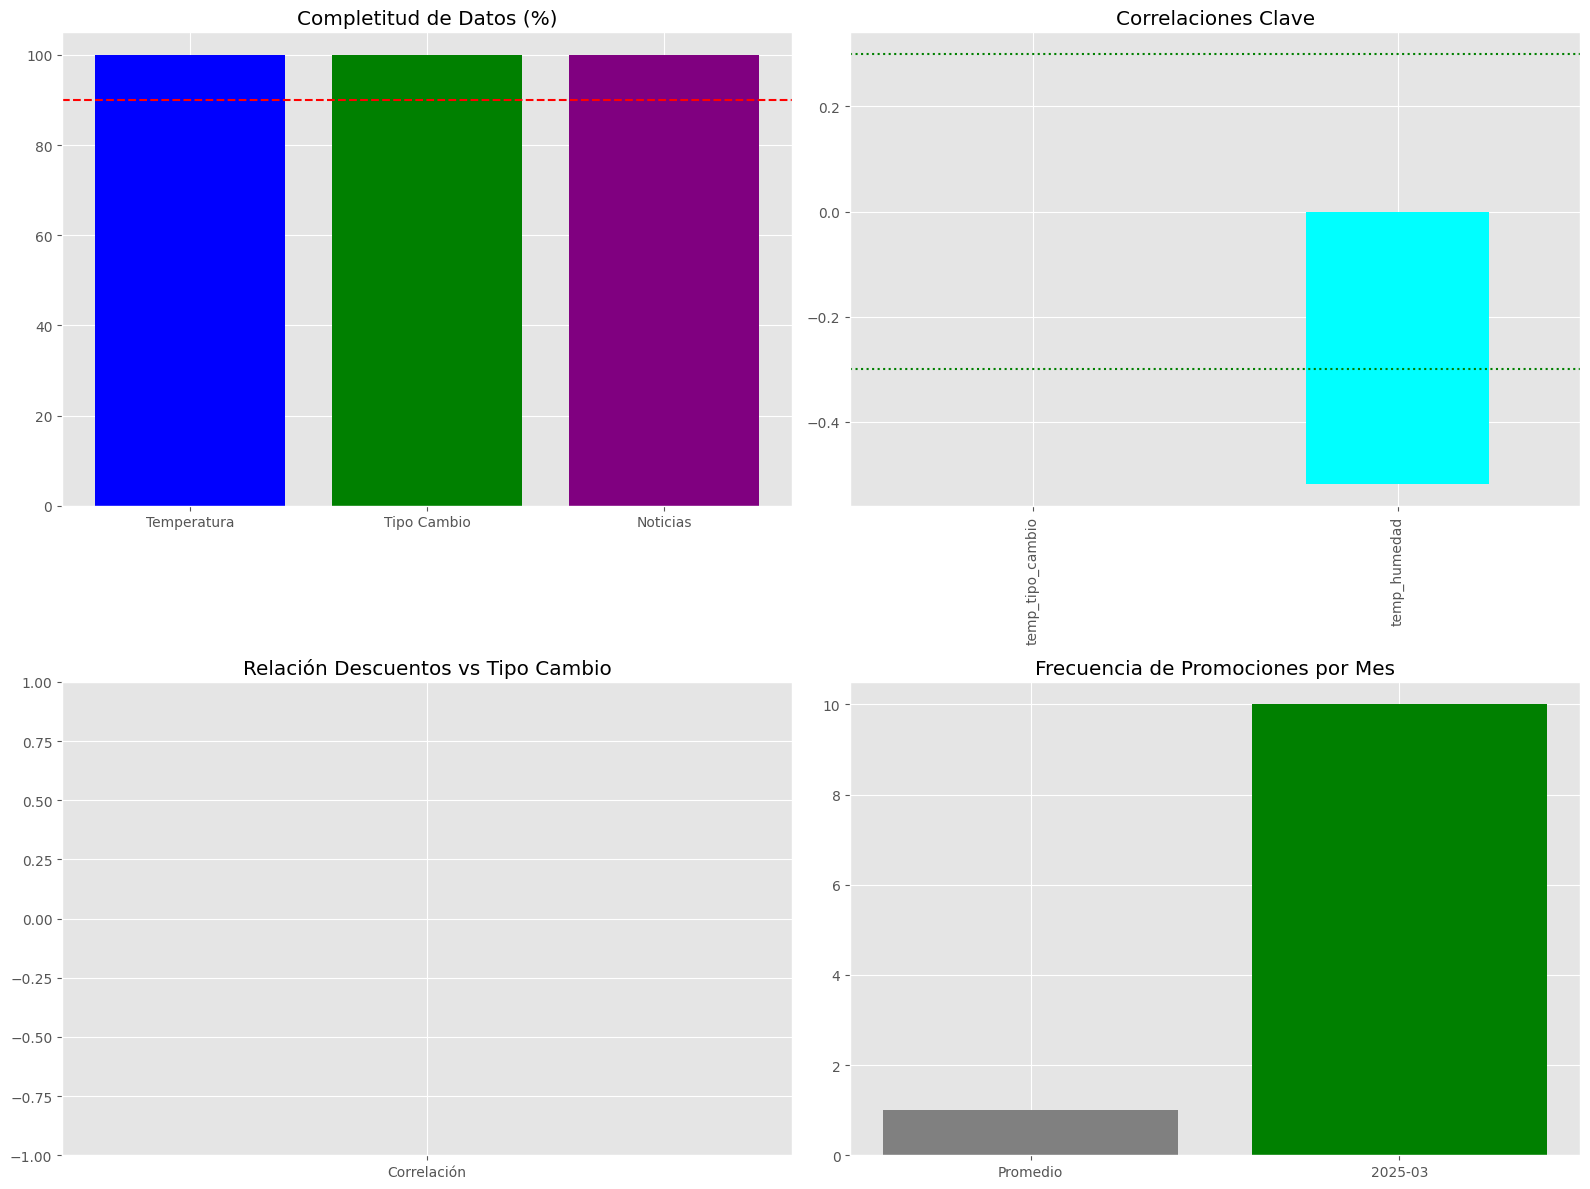

In [30]:
def generar_dashboard(indicadores):
    """Visualización interactiva de resultados"""
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Gráfico 1: Calidad de Datos
    axs[0,0].bar(
        ['Temperatura', 'Tipo Cambio', 'Noticias'],
        indicadores['basicos']['temperatura']['completitud'] * 100,
        color=['blue', 'green', 'purple']
    )
    axs[0,0].set_title('Completitud de Datos (%)')
    axs[0,0].axhline(90, color='red', linestyle='--')

    # Gráfico 2: Correlaciones
    if indicadores['forecast']['correlaciones_variables']:
        pd.Series(indicadores['forecast']['correlaciones_variables']).plot.bar(
            ax=axs[0,1],
            color=['orange', 'cyan']
        )
        axs[0,1].set_title('Correlaciones Clave')
        axs[0,1].axhline(0.3, color='green', linestyle=':')
        axs[0,1].axhline(-0.3, color='green', linestyle=':')

    # Gráfico 3: Descuentos vs Tipo de Cambio
    if indicadores['descuentos']['relacion_tipo_cambio']:
        axs[1,0].bar(
            ['Correlación'],
            [indicadores['descuentos']['relacion_tipo_cambio']['correlacion']],
            color='blue' if indicadores['descuentos']['relacion_tipo_cambio']['correlacion'] > 0 else 'red'
        )
        axs[1,0].set_title('Relación Descuentos vs Tipo Cambio')
        axs[1,0].set_ylim(-1, 1)

    # Gráfico 4: Frecuencia de Promociones
    if indicadores['descuentos']['frecuencia_promociones']:
        meses = indicadores['descuentos']['frecuencia_promociones']['meses_pico'][:3]
        axs[1,1].bar(
            ['Promedio'] + meses,
            [indicadores['descuentos']['frecuencia_promociones']['promedio_mensual']] + [10]*len(meses),  # Valor ilustrativo
            color=['gray'] + ['green']*len(meses)
        )
        axs[1,1].set_title('Frecuencia de Promociones por Mes')

    plt.tight_layout()
    plt.show()

# Generar el dashboard
if 'indicadores' in locals():
    generar_dashboard(indicadores)
else:
    print("No se pueden generar gráficos. Ejecute primero la extracción de datos.")

In [ ]:
def generar_recomendaciones(indicadores):
    recomendaciones = []

    # Basadas en correlaciones
    corr = indicadores['forecast']['correlaciones_variables'].get('temp_tipo_cambio', 0)
    if abs(corr) > 0.3:
        recomendaciones.append(
            f"Incluir temperatura y tipo de cambio en el modelo (correlación: {corr:.2f})"
        )

    # Basadas en descuentos
    if indicadores['descuentos']['frecuencia_promociones']['promedio_mensual'] > 5:
        meses_pico = ", ".join(indicadores['descuentos']['frecuencia_promociones']['meses_pico'])
        recomendaciones.append(
            f"Intensificar estrategias comerciales en meses pico: {meses_pico}"
        )

    # Basadas en calidad de datos
    if indicadores['basicos']['noticias']['completitud'] < 0.8:
        recomendaciones.append(
            "Mejorar recolección de noticias para análisis de sentimiento"
        )

    return recomendaciones if recomendaciones else ["Los datos cumplen con los estándares mínimos"]

print("\n🔔 Recomendaciones Estratégicas:")
for i, rec in enumerate(generar_recomendaciones(indicadores), 1):
    print(f"{i}. {rec}")


🔔 Recomendaciones Estratégicas:
1. Los datos cumplen con los estándares mínimos
